In [1]:
from functools import cached_property
from mlflux.predictor import FluxBulkANN
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

psd = xr.load_dataset('../../data/processed/psd.nc')
from mlflux.datafunc import data_split_psd

split=[[77, 69, 83, 78], [87, 72, 71], [68, 67, 73]]
# split=[[77, 69, 83, 78, 68, 67, 73], [68, 67, 73], [87, 72, 71]]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='time')

Training samples: 7528
Validating samples: 879
Testing samples: 1666


### ANN UQ for bulk formula

In [10]:
class Flux11(FluxBulkANN):
    @cached_property
    def Xscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([20]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        x1_vis = np.linspace(0,20,100)
        X_uniform = np.hstack([x1_vis.reshape(-1,1),])
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        # REMEMBER the pred_var function already squared var_net outputs
        return (self.pred_mean(self.X_uniform).detach(), self.pred_var(self.X_uniform).detach())

In [11]:
# Right now do it like this
from torch.utils.data import Dataset

# from mlflux.ann import sample_weights

def sample_weights (x):
    return np.where(x > 18, 1.0, 1.0)

class RealFluxDatasetVar(Dataset):
    def __init__(self, ds, weightfunc=sample_weights):
        
        # Assemble input and output features
        self.X = torch.tensor(np.hstack([ds['U'].values.reshape(-1,1),]).astype('float32'))
        self.Y = torch.tensor(np.hstack([(ds['taucx']-ds['taubx']).values.reshape(-1,1),]).astype('float32'))
        self.Bulk = torch.tensor(np.hstack([ds['taubx'].values.reshape(-1,1),]).astype('float32'))
            
        # Weights according to weightfunc of choice
        # TODO: only depends on wind. How to write this better?
        self.W = torch.tensor(weightfunc(self.X[:,0]).astype('float32'))
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.W[idx]

# Initiate the Dataset class and use default weighting
para1 = {'n_in':1,'n_out':1,'hidden_channels':[16]}
para2 = {'n_in':1,'n_out':1,'hidden_channels':[16]}
model = Flux11({'bulk_algorithm':'coare3p6', 'var_ann_para':para2})

training_data = RealFluxDatasetVar(training_ds, weightfunc=sample_weights)
validating_data = RealFluxDatasetVar(validating_ds, weightfunc=sample_weights)


In [12]:
training_paras = {'batchsize':100, 'num_epochs':200, 'lr':5e-3, 'gamma':0.2}
log, training_data_cp = model.fit(training_data,validating_data,training_paras)

Epoch [1/200], Loss: -23892.23210626
Epoch [2/200], Loss: -24539.50411718
Epoch [3/200], Loss: -23168.69254768
Epoch [4/200], Loss: -24253.82587403
Epoch [5/200], Loss: -24128.85287446
Epoch [6/200], Loss: -20849.60545202
Epoch [7/200], Loss: -23460.46566523
Epoch [8/200], Loss: -24616.96703907
Epoch [9/200], Loss: -21421.13748373
Epoch [10/200], Loss: -25311.34756298
Epoch [11/200], Loss: -25711.66100932
Epoch [12/200], Loss: -10078.44117794
Epoch [13/200], Loss: -20816.52060057
Epoch [14/200], Loss: -23487.03123080
Epoch [15/200], Loss: -17423.24765180
Epoch [16/200], Loss: -24807.99966985
Epoch [17/200], Loss: -21905.16122874
Epoch [18/200], Loss: -7756.56179158
Epoch [19/200], Loss: -15835.80209730
Epoch [20/200], Loss: -23275.80222164
Epoch [21/200], Loss: -23514.36254922
Epoch [22/200], Loss: -24417.15918319
Epoch [23/200], Loss: -25581.75723912
Epoch [24/200], Loss: -25190.90237021
Epoch [25/200], Loss: -25928.89959983
Epoch [26/200], Loss: -24659.48781554
Epoch [27/200], Loss: 

(0.0, 0.02)

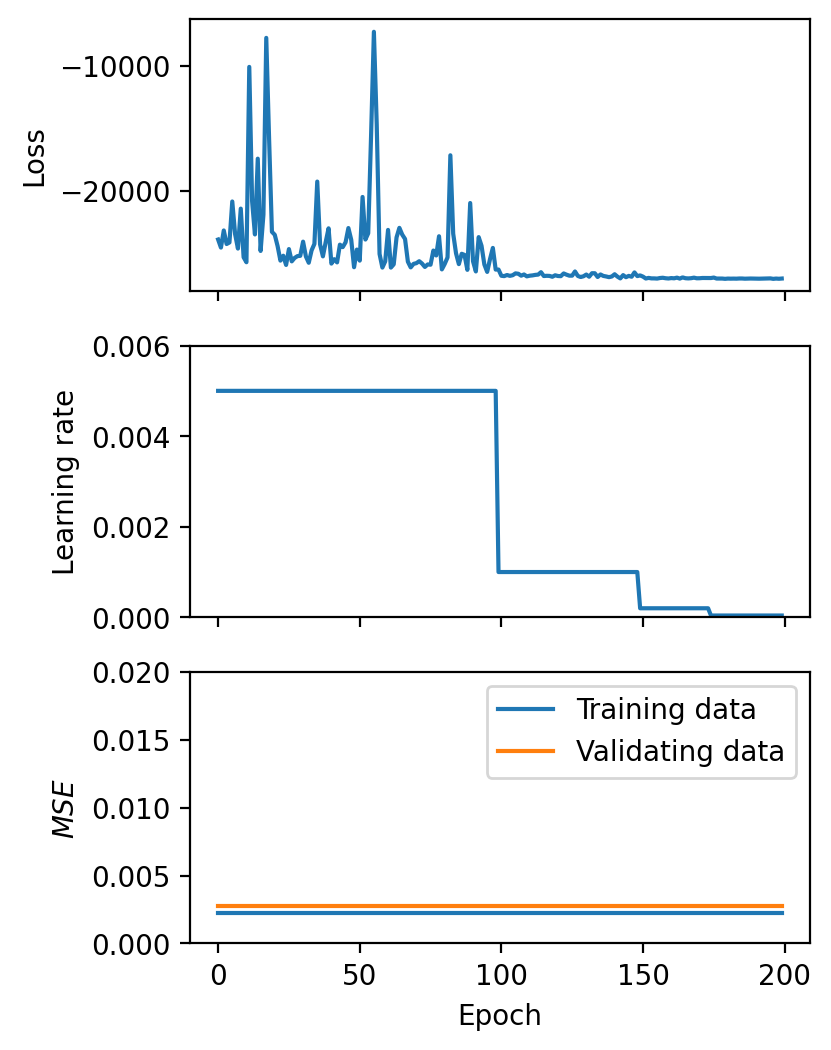

In [13]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
# axes[0].set_ylim([-400,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])
axes[2].plot(log['training_mse'], label='Training data')
axes[2].plot(log['validating_mse'], label='Validating data')
axes[2].set_ylabel(r'$MSE$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].set_ylim([0,0.02])

### Pure ANN

In [18]:
from mlflux.predictor import FluxANNs
from mlflux.ann import RealFluxDataset

In [19]:

class Flux11(FluxANNs):
    @cached_property
    def Xscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([20]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        x1_vis = np.linspace(0,20,100)
        X_uniform = np.hstack([x1_vis.reshape(-1,1),])
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        # REMEMBER the pred_var function already squared var_net outputs
        return (self.pred_mean(self.X_uniform).detach(), self.pred_var(self.X_uniform).detach())

In [20]:
''' 1D input (wind speed) - 1D output (momentum flux)
'''
para1 = {'n_in':1,'n_out':1,'hidden_channels':[16]}
para2 = {'n_in':1,'n_out':1,'hidden_channels':[16]}
anns = Flux11({'mean_ann_para':para1, 'var_ann_para':para2})

# Initiate the Dataset class and use default weighting
training_data = RealFluxDataset(training_ds, input_keys=['U'], output_keys=['taucx'],
                                weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=['U'], output_keys=['taucx'],
                                weightfunc=sample_weights)
testing_data = RealFluxDataset(testing_ds, input_keys=['U'], output_keys=['taucx'],
                                weightfunc=sample_weights)

training_paras = {'batchsize':100, 'num_epochs':200, 'lr':5e-3, 'gamma':0.2}
log, training_data_cp = anns.fit(training_data,validating_data,training_paras)

Epoch [1/200], Loss: -159.84439531
Epoch [2/200], Loss: -26.70748278
Epoch [3/200], Loss: -71.41040388
Epoch [4/200], Loss: -73.10665425
Epoch [5/200], Loss: -74.45268164
Epoch [6/200], Loss: -76.02257229
Epoch [7/200], Loss: -77.83302597
Epoch [8/200], Loss: -79.89877909
Epoch [9/200], Loss: -82.24990278
Epoch [10/200], Loss: -84.88430140
Epoch [11/200], Loss: -87.89123966
Epoch [12/200], Loss: -91.26652393
Epoch [13/200], Loss: -95.10401920
Epoch [14/200], Loss: -99.50576583
Epoch [15/200], Loss: -104.57432456
Epoch [16/200], Loss: -110.48802496
Epoch [17/200], Loss: -117.48940396
Epoch [18/200], Loss: -125.93886633
Epoch [19/200], Loss: -136.44580008
Epoch [20/200], Loss: -150.05816663
Epoch [21/200], Loss: -168.70943491
Epoch [22/200], Loss: -195.40773705
Epoch [23/200], Loss: -223.89416494
Epoch [24/200], Loss: -227.69166483
Epoch [25/200], Loss: -231.76362443
Epoch [26/200], Loss: -233.83332843
Epoch [27/200], Loss: -233.45074769
Epoch [28/200], Loss: -234.01854957
Epoch [29/200]

(0.0, 1.0)

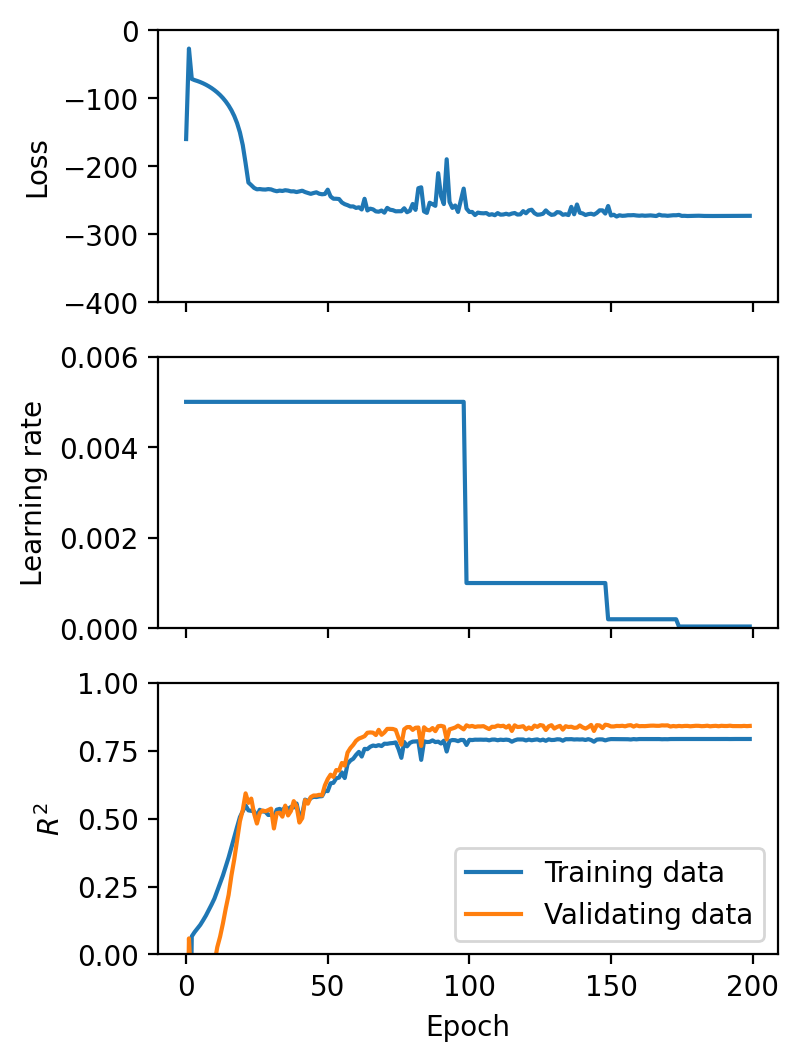

In [21]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
axes[0].set_ylim([-400,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])
axes[2].plot(log['training_r2'], label='Training data')
axes[2].plot(log['validating_r2'], label='Validating data')
axes[2].set_ylabel(r'$R^2$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].set_ylim([0,1])

In [32]:
## Need to compute MSE metrics differently
training_data = RealFluxDatasetVar(training_ds, weightfunc=sample_weights)
validating_data = RealFluxDatasetVar(validating_ds, weightfunc=sample_weights)
training_data.mse_bulk = torch.mean(training_data.Y**2).detach()
training_data.r2_bulk = (1 - torch.mean(training_data.Y**2)/torch.var(training_data.Y+training_data.Bulk)).detach()
validating_data.mse_bulk = torch.mean(validating_data.Y**2).detach()
validating_data.r2_bulk = (1 - torch.mean(validating_data.Y**2)/torch.var(validating_data.Y+validating_data.Bulk)).detach()

print('Training data, momentum, Bulk MSE %.6f, r2 %.6f' %(training_data.mse_bulk, training_data.r2_bulk))
print('Training data, momentum, ANNs MSE %.6f, r2 %.6f' %(log['training_mse'][-1], log['training_r2'][-1]))
print('Validating data, momentum, Bulk MSE %.6f, r2 %.6f' %(validating_data.mse_bulk, validating_data.r2_bulk))
print('Validating data, momentum, ANNs MSE %.6f, r2 %.6f' %(log['validating_mse'][-1], log['validating_r2'][-1]))

Training data, momentum, Bulk MSE 0.002248, r2 0.805014
Training data, momentum, ANNs MSE 0.002389, r2 0.792807
Validating data, momentum, Bulk MSE 0.002765, r2 0.875874
Validating data, momentum, ANNs MSE 0.003546, r2 0.840814


Text(0.5, 1.0, 'Prediction by ANN')

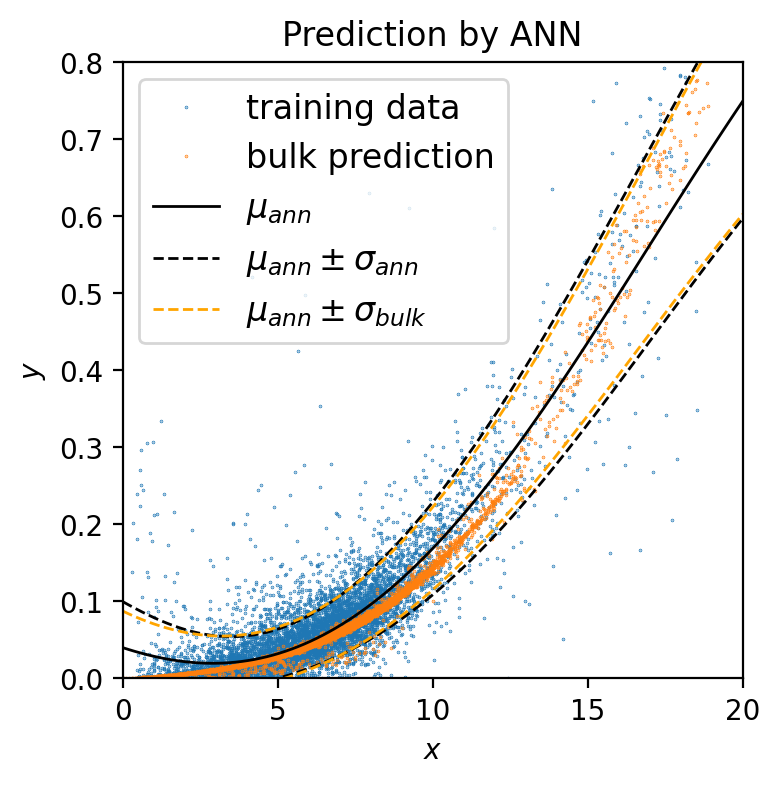

In [39]:
mean_uniform, var_uniform = model.evaluate_uniform()
mean_anns, var_anns = anns.evaluate_uniform()

plt.figure(figsize=(4,4), dpi=200)
plt.plot(training_data.X[:], training_data.Y[:]+training_data.Bulk[:], '.', markersize=0.5, label='training data')
plt.plot(training_data.X[:], training_data.Bulk[:], '.', markersize=0.5, label='bulk prediction')
plt.plot(model.X_uniform,mean_anns,'-', lw=1, color='k', label=r'$\mu_{ann}$')
plt.plot(model.X_uniform,mean_anns-var_anns**0.5,'--', lw=1, color='k', label='$\mu_{ann} \pm \sigma_{ann}$')
plt.plot(model.X_uniform,mean_anns+var_anns**0.5,'--', lw=1, color='k')
plt.plot(model.X_uniform,mean_anns-var_uniform**0.5,'--', lw=1, color='orange', label='$\mu_{ann} \pm \sigma_{bulk}$')
plt.plot(model.X_uniform,mean_anns+var_uniform**0.5,'--', lw=1, color='orange')


plt.xlim([0,20]) 
plt.xticks([0,5,10,15,20])
plt.ylim([0,0.8])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left', fontsize=12)
plt.title('Prediction by ANN' )